In [3]:
## Imports 

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore

from src.data_processing.lstm_data_preprocessing import get_token_features, get_sliding_windows
from src.data_processing.loader import load_token_data, load_data_file
from src.data_processing.processor import remove_price_anomalies
from src.visualisation.price_plotter import plot_token_price

In [ ]:
# Load and prep data
sequence_length = 30

token_datasets = []  # Store data for all tokens
with load_data_file("cluster_2_tokens.txt") as f:
    token_addresses = f.read().splitlines()[:-1]


for token_address in token_addresses:
    # Load data
    df = load_token_data(token_address)
       
    # Clean data for price features
    cleaned_df = remove_price_anomalies(df)
    feature_matrix = get_token_features(token_address, relative_time=True)
    X, y = get_sliding_windows(feature_matrix, sequence_length=sequence_length, prediction_horizon=5)
    
    if len(X) > 0 and len(y) > 0 and len(X) == len(y):  # Make sure we have data
        if np.isnan(X).any() or np.isinf(X).any() or np.isnan(y).any() or np.isinf(y).any():
            continue
        token_datasets.append((X, y, token_address))

print(f"Dataset of: {len(token_datasets)} tokens")

# Combine all token data
all_X = np.vstack([data[0] for data in token_datasets])
all_y = np.vstack([data[1].reshape(-1, 1) for data in token_datasets])


# Scale features
feature_scaler = StandardScaler()
num_samples, time_steps, features = all_X.shape
X_reshaped = all_X.reshape(num_samples * time_steps, features)
X_scaled = feature_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, time_steps, features)

# Scale target variable also using StandardScaler to preserve direction
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(all_y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)


c:\Users\matth\Uni work\Year 3\Spring Semester\CM3203 - One Semester Individual Project\Project Environment\CM3202-Venv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\matth\Uni work\Year 3\Spring Semester\CM3203 - One Semester Individual Project\Project Environment\CM3202-Venv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\matth\Uni work\Year 3\Spring Semester\CM3203 - One Semester Individual Project\Project Environment\CM3202-Venv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\matth\Uni work\Year 3\Spring Semester\CM3203 - One Semester Individual Project\Project Environment\CM3202-Venv\Lib\site-packages\numpy\_core\fromnumeri

Dataset of: 378 tokens


In [5]:
# Build the LSTM model
use_saved_model = True
if not use_saved_model:
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, 
                input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer - predicting the price change

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )
else:
    model = load_model("badboyting.keras")
    model.summary()

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to get real values
y_pred_actual = y_scaler.inverse_transform(y_pred)
y_test_actual = y_scaler.inverse_transform(y_test)

# Evaluate the model
mse = np.mean((y_pred_actual - y_test_actual) ** 2)
print(f"Mean Squared Error: {mse}")

c:\Users\matth\Uni work\Year 3\Spring Semester\CM3203 - One Semester Individual Project\Project Environment\CM3202-Venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,504 (244.16 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,253 (122.09 KB)

6185/6185 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
Mean Squared Error: 0.005633843615571153


In [6]:
# Modified MAPE calculation with safeguards
def calculate_mape(y_true, y_pred):
    # Filter out zeros in actual values to avoid division by zero
    mask = y_true.flatten() != 0
    if not np.any(mask):  # If all values are zero
        return "Cannot calculate MAPE: All actual values are zero"
    
    # Calculate MAPE only for non-zero actual values
    percentage_errors = np.abs((y_true.flatten()[mask] - y_pred.flatten()[mask]) / y_true.flatten()[mask]) * 100
    
    # Remove infinite or extremely large values (optional)
    filtered_errors = percentage_errors[~np.isinf(percentage_errors) & (percentage_errors < 1000)]
    
    if len(filtered_errors) == 0:
        return "Cannot calculate meaningful MAPE: Errors too large or undefined"
    
    return np.mean(filtered_errors)

# Using the function
mape_value = calculate_mape(y_test_actual, y_pred_actual)
print(f"Mean Absolute Percentage Error: {mape_value}%")

Mean Absolute Percentage Error: 132.79803602954675%


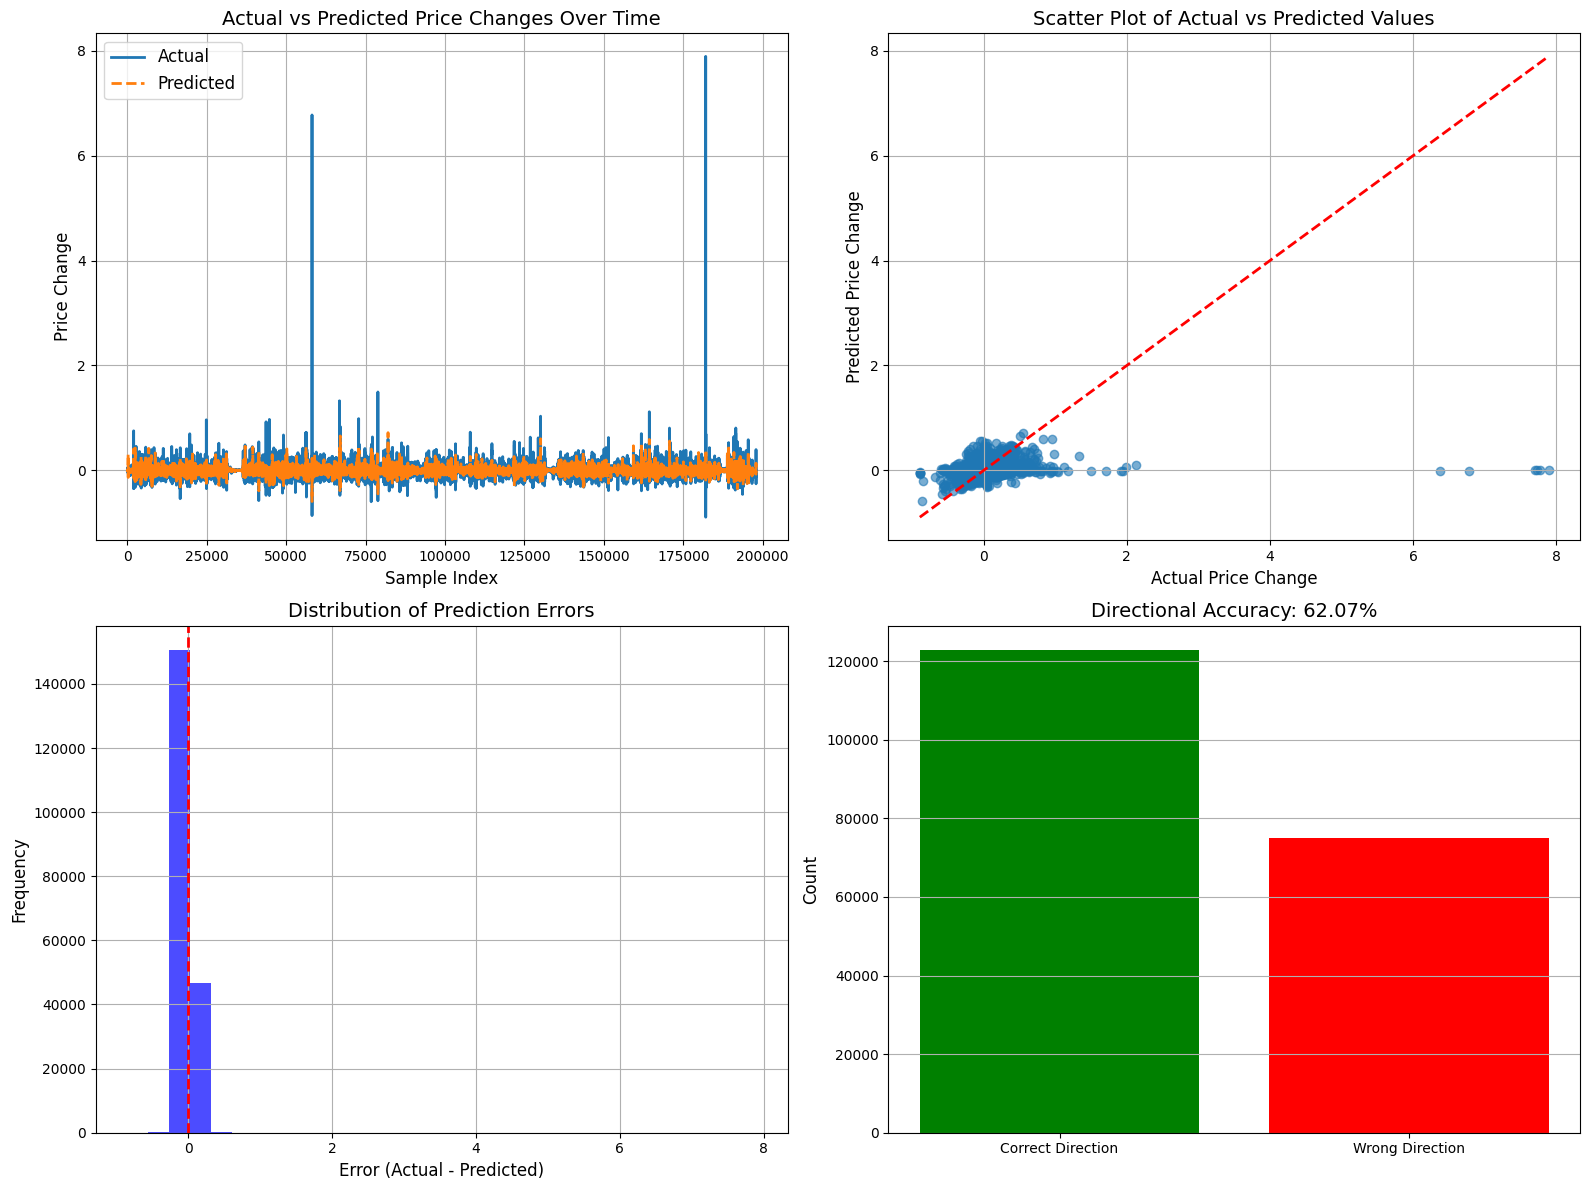

In [7]:
# Plot actual vs predicted

def plot_actual_vs_predicted(y_test_actual, y_pred_actual):
    """
    Create comprehensive plots comparing actual vs predicted price changes.
    
    Parameters:
    y_test_actual - numpy array of actual price changes
    y_pred_actual - numpy array of predicted price changes
    """
    # Ensure inputs are flattened
    y_test_actual = y_test_actual.flatten()
    y_pred_actual = y_pred_actual.flatten()
    
    # Create a figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Time series plot of actual vs predicted values
    axs[0, 0].plot(y_test_actual, label='Actual', linewidth=2)
    axs[0, 0].plot(y_pred_actual, label='Predicted', linewidth=2, linestyle='--')
    axs[0, 0].set_title('Actual vs Predicted Price Changes Over Time', fontsize=14)
    axs[0, 0].set_xlabel('Sample Index', fontsize=12)
    axs[0, 0].set_ylabel('Price Change', fontsize=12)
    axs[0, 0].legend(fontsize=12)
    axs[0, 0].grid(True)
    
    # 2. Scatter plot of actual vs predicted with diagonal line
    axs[0, 1].scatter(y_test_actual, y_pred_actual, alpha=0.6)
    
    # Add diagonal line (perfect predictions)
    min_val = min(y_test_actual.min(), y_pred_actual.min())
    max_val = max(y_test_actual.max(), y_pred_actual.max())
    axs[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    axs[0, 1].set_title('Scatter Plot of Actual vs Predicted Values', fontsize=14)
    axs[0, 1].set_xlabel('Actual Price Change', fontsize=12)
    axs[0, 1].set_ylabel('Predicted Price Change', fontsize=12)
    axs[0, 1].grid(True)
    
    # 3. Histogram of errors
    errors = y_test_actual - y_pred_actual
    axs[1, 0].hist(errors, bins=30, alpha=0.7, color='blue')
    axs[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axs[1, 0].set_title('Distribution of Prediction Errors', fontsize=14)
    axs[1, 0].set_xlabel('Error (Actual - Predicted)', fontsize=12)
    axs[1, 0].set_ylabel('Frequency', fontsize=12)
    axs[1, 0].grid(True)
    
    # 4. Directional accuracy visualization
    correct_direction = np.sign(y_test_actual) == np.sign(y_pred_actual)
    axs[1, 1].bar(['Correct Direction', 'Wrong Direction'], 
                 [np.sum(correct_direction), np.sum(~correct_direction)],
                 color=['green', 'red'])
    
    directional_accuracy = np.mean(correct_direction) * 100
    axs[1, 1].set_title(f'Directional Accuracy: {directional_accuracy:.2f}%', fontsize=14)
    axs[1, 1].set_ylabel('Count', fontsize=12)
    axs[1, 1].grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test_actual, y_pred_actual)

In [16]:
# Evaluate accuracy of predictions for the top x percent of predictions by size of change
# 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
 
def compare_estimate_to_real(y_test_actual, y_pred_actual, percentage=5):
    """
    Create comprehensive plots comparing actual vs predicted price changes.
    
    Parameters:
    y_test_actual - numpy array of actual price changes
    y_pred_actual - numpy array of predicted price changes
    """
    # Ensure inputs are flattened
    y_test_actual = y_test_actual.flatten()
    y_pred_actual = y_pred_actual.flatten()

    # Find the indices of the top positive and negative predicted changes
    num_to_highlight = int(len(y_pred_actual) * percentage / 100)
    
    # Sort by absolute value to get largest changes in either direction
    sorted_indices = np.argsort(np.abs(y_pred_actual))[::-1]
    top_indices = sorted_indices[:num_to_highlight]

    top_predicted = y_pred_actual[top_indices]
    real_equivalents = y_test_actual[top_indices]

    for pred, real in zip(top_predicted, real_equivalents):
        print(f"pred: {pred}, real: {real}")
    

     # Compute error metrics
    overall_mae = mean_absolute_error(y_test_actual, y_pred_actual)
    top_mae = mean_absolute_error(real_equivalents, top_predicted)

    overall_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    top_rmse = np.sqrt(mean_squared_error(real_equivalents, top_predicted))

    overall_r2 = r2_score(y_test_actual, y_pred_actual)
    top_r2 = r2_score(real_equivalents, top_predicted)

    # Directional Accuracy: % of cases where sign of predicted matches actual
    overall_directional_accuracy = np.mean(np.sign(y_pred_actual) == np.sign(y_test_actual))
    top_directional_accuracy = np.mean(np.sign(top_predicted) == np.sign(real_equivalents))

    print(f"Overall MAE: {overall_mae:.4f}, Top {percentage}% MAE: {top_mae:.4f}")
    print(f"Overall RMSE: {overall_rmse:.4f}, Top {percentage}% RMSE: {top_rmse:.4f}")
    print(f"Overall R²: {overall_r2:.4f}, Top {percentage}% R²: {top_r2:.4f}")
    print(f"Overall Directional Accuracy: {overall_directional_accuracy:.2%}")
    print(f"Top {percentage}% Directional Accuracy: {top_directional_accuracy:.2%}")


compare_estimate_to_real(y_test_actual, y_pred_actual, percentage=0.5)
    

pred: 0.7183367609977722, real: 0.5549185539462922
pred: 0.656400203704834, real: 0.5124709936471838
pred: 0.6024854183197021, real: 0.8222246448964157
pred: -0.5935861468315125, real: -0.8628294864007712
pred: 0.5889226198196411, real: 0.9574939317192477
pred: 0.5590381026268005, real: -0.020839678919782556
pred: 0.5512693524360657, real: -0.046640613992077196
pred: 0.5278134346008301, real: 0.01076604051211083
pred: 0.5190359354019165, real: 0.05162837602383475
pred: 0.5186600685119629, real: 0.17561409785292392
pred: 0.4769412577152252, real: 0.37594317162208996
pred: 0.47096681594848633, real: -0.09555634436457083
pred: 0.46834316849708557, real: 0.25149652397924616
pred: 0.4639447331428528, real: 0.4035336526081028
pred: 0.4633796513080597, real: 0.38358300208572893
pred: 0.45932626724243164, real: 0.049954776644342225
pred: 0.45687615871429443, real: 0.010374877240780567
pred: 0.4561883509159088, real: -0.1510886853913267
pred: 0.45571547746658325, real: 0.34886748674528295
pred:

In [ ]:
def test_model_on_token(cleaned_df, y_pred_actual, percentage=10):
    """
    Plot the actual price chart and highlight where the model predicts the largest price changes.
    
    Parameters:
    cleaned_df - The original DataFrame with token prices
    y_pred_actual - numpy array of predicted price changes (percentage)
    percentage - Top percentage of price changes to highlight (default: 10%)
    """
    import matplotlib.dates as mdates
    from matplotlib.patches import Rectangle
    
    # Flatten the predictions if needed
    y_pred_actual = y_pred_actual.flatten()
    
    # Determine where the test predictions start in the cleaned dataframe
    test_start = len(cleaned_df) - len(y_pred_actual)
    
    # Get the actual token prices for the test period
    actual_prices = cleaned_df['token_price'].values[test_start:]
    
    # Get the timestamps or indices
    if 'block_time' in cleaned_df.columns:
        time_axis = cleaned_df['block_time'].values[test_start:]
    elif 'slot' in cleaned_df.columns:
        time_axis = cleaned_df['slot'].values[test_start:]
    else:
        time_axis = np.arange(len(actual_prices))
    
    # Find the indices of the top positive and negative predicted changes
    num_to_highlight = int(len(y_pred_actual) * percentage / 100)
    
    # Sort by absolute value to get largest changes in either direction
    sorted_indices = np.argsort(np.abs(y_pred_actual))[::-1]
    top_indices = sorted_indices[:num_to_highlight]
    
    # Separate positive and negative changes
    positive_indices = [i for i in top_indices if y_pred_actual[i] > 0]
    negative_indices = [i for i in top_indices if y_pred_actual[i] < 0]
    
    # Create the plot
    plt.figure(figsize=(14, 7))
    
    # Plot the actual price line
    plt.plot(time_axis, actual_prices, label='Actual Price', color='blue', linewidth=2)
    
    # Plot markers for top positive predicted changes
    if positive_indices:
        plt.scatter(
            time_axis[positive_indices], 
            actual_prices[positive_indices], 
            color='green', 
            s=100, 
            marker='^', 
            label=f'Top {percentage}% Positive Predicted Changes'
        )
        
        # Annotate positive changes with the predicted percentage
        for idx in positive_indices:
            plt.annotate(
                f"+{y_pred_actual[idx]:.2f}%", 
                (time_axis[idx], actual_prices[idx]),
                xytext=(5, 10),
                textcoords='offset points',
                color='darkgreen',
                fontweight='bold'
            )
    
    # Plot markers for top negative predicted changes
    if negative_indices:
        plt.scatter(
            time_axis[negative_indices], 
            actual_prices[negative_indices], 
            color='red', 
            s=100, 
            marker='v', 
            label=f'Top {percentage}% Negative Predicted Changes'
        )
        
        # Annotate negative changes with the predicted percentage
        for idx in negative_indices:
            plt.annotate(
                f"{y_pred_actual[idx]:.2f}%", 
                (time_axis[idx], actual_prices[idx]),
                xytext=(5, -20),
                textcoords='offset points',
                color='darkred',
                fontweight='bold'
            )
    
    # Add titles and labels
    plt.title(f'Token Price with Top {percentage}% Predicted Price Changes', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Token Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Format x-axis if using datetime
    if hasattr(time_axis[0], 'dtype') and np.issubdtype(time_axis[0].dtype, np.datetime64):
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()
    
    # Also create a second plot showing the distribution of predicted changes
    plt.figure(figsize=(12, 5))
    
    # Plot histogram of all predicted changes
    plt.hist(y_pred_actual, bins=30, alpha=0.5, color='blue', label='All Predictions')
    
    # Highlight thresholds used for top changes
    if len(y_pred_actual) > 0:
        # Find thresholds
        sorted_positive = np.sort(y_pred_actual[y_pred_actual > 0])
        sorted_negative = np.sort(y_pred_actual[y_pred_actual < 0])
        
        positive_threshold = sorted_positive[-min(num_to_highlight, len(sorted_positive))] if len(sorted_positive) > 0 else 0
        negative_threshold = sorted_negative[min(num_to_highlight, len(sorted_negative))-1] if len(sorted_negative) > 0 else 0
        
        # Plot vertical lines at thresholds
        if positive_threshold > 0:
            plt.axvline(x=positive_threshold, color='green', linestyle='--', 
                       label=f'Positive Threshold: {positive_threshold:.2f}%')
        
        if negative_threshold < 0:
            plt.axvline(x=negative_threshold, color='red', linestyle='--',
                       label=f'Negative Threshold: {negative_threshold:.2f}%')
    
    plt.title('Distribution of Predicted Price Changes', fontsize=16)
    plt.xlabel('Predicted Change (%)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_top_predicted_price_changes(cleaned_df, y_pred_actual, percentage=0.5)

NameError: name 'plot_top_predicted_price_changes' is not defined

In [ ]:
# Save the entire model (architecture, weights, optimizer state)
model.save('full_lstm_model.h5')  # For TF 2.x, you can also use .keras extension

In [ ]:
model.save('badboyting.keras')

In [ ]:
compare_estimate_to_real(y_test_actual, y_pred_actual, percentage=0.5)

Overall MAE: 0.0395, Top 0.5% MAE: 0.1297
Overall RMSE: 0.0751, Top 0.5% RMSE: 0.1789
Overall R²: 0.0907, Top 0.5% R²: 0.2967
Overall Directional Accuracy: 62.07%
Top 0.5% Directional Accuracy: 83.42%
